# Process ch 1-4 with changing watertank shift
here I will process channel 1-4 with the changing watertank shift.
So the watertank value measurement time will fit to the DTS measurement time.
This will give some data gaps, because the Watertank temperature is not always avaible.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import numpy as np
import matplotlib.dates as mdates
from scipy import optimize
import matplotlib.patches as patches
from collections import defaultdict
from datetime import timedelta
from datetime import datetime
import pickle
from ipywidgets import interact
import ipywidgets as widgets
from copy import deepcopy#, copy
import statistics
#from random import randrange
from bokeh.io import export_png, export_svgs
from bokeh.models import ColumnDataSource, DataTable, TableColumn
from shutil import copy2 as copy_file

import plotly
import plotly.express as px
import kaleido

from my_func_mvw.functions_import_my_database import import_my_database_pickle, import_my_database_csv, merge_data_year
from my_func_mvw.functions import find_nearest_date, watertank_shift, calc_diff_between_channels, read_pickle, write_pickle, temp_watertank_func, check_first_last_date, calc_stat_of_difference, cut_dataframe_to_range_tlogger, check_processed_data, calc_mean_for_each_segment, plot_segments_mean_correction, const_shift_data

plot_save=True #True False

path_to_my_database = r"..\Alsdorf\Daten\my_database" #".\\"
importer = "pickle" #csv pickle #does not work for tlogger at the moment

print("Some Version information of the imported packages")
print(f"pandas version: {pd.__version__}")
print(f"pickle version: {pickle.format_version}")

Some Version information of the imported packages
pandas version: 1.2.3
pickle version: 4.0


In [2]:
# Load pickle Data
if importer == "pickle":
    data_all = read_pickle(path_to_my_database + "\..\my_database_additional_local\data_all")

# delete egrt cable channels
for egrt_chan in ["5","6","7","8"]:
    del data_all[egrt_chan]

In [3]:
# import tlogger
# read csv
# Tlogger_PT1000 = pd.read_csv(path_to_my_database + "\\t_logger_watertank\\Tlogger_PT1000.csv", index_col=[0])
# Tlogger_PT100  = pd.read_csv(path_to_my_database + "\\t_logger_watertank\\Tlogger_PT100_outdated.csv",index_col=[0])
# Tlogger_PT100.index.names=["Date"]; Tlogger_PT1000.index.names=["Date"]
# Tlogger_PT100.index = pd.to_datetime(Tlogger_PT100.index); Tlogger_PT1000.index = pd.to_datetime(Tlogger_PT1000.index)

#read_pickle
df_Tlogger_PT1000 = read_pickle(path_to_my_database + "\\t_logger_watertank\\Tlogger_PT1000")
df_Tlogger_PT100  = read_pickle(path_to_my_database + "\\t_logger_watertank\\Tlogger_PT100_outdated")

watertank_T_range_min = df_Tlogger_PT100.index.min()
watertank_T_range_max = df_Tlogger_PT100.index.max()

df_Tlogger_PT100

,Channel1-Watertank_PT100,Channel2-Air,Channel1-PT100_rolling_mean
2021-06-07 12:12:40,23.4,25.8,23.5
2021-06-07 12:13:40,23.5,25.4,23.5
2021-06-07 12:14:40,23.4,25.2,23.5
2021-06-07 12:15:40,23.5,24.9,23.5
2021-06-07 12:16:40,23.5,24.8,23.5
...,...,...,...
2021-08-09 10:28:14,20.6,NaN,20.6
2021-08-09 10:31:14,20.6,NaN,20.6
2021-08-09 10:34:14,20.6,NaN,20.6
2021-08-09 10:37:13,20.6,NaN,20.6


In [4]:
data_all_processed = cut_dataframe_to_range_tlogger(channels=["1","2","3","4"],data=data_all,watertank_T_range_min=watertank_T_range_min, watertank_T_range_max=watertank_T_range_max)


Channel: 1; Number of dates: 2928
first (oldes) date: 2021-06-07 12:12:22
last (newest) date: 2021-08-09 00:09:15

Channel: 2; Number of dates: 2928
first (oldes) date: 2021-06-07 15:28:30
last (newest) date: 2021-08-09 03:25:23

Channel: 3; Number of dates: 2928
first (oldes) date: 2021-06-07 17:08:35
last (newest) date: 2021-08-09 05:05:28

Channel: 4; Number of dates: 2928
first (oldes) date: 2021-06-07 19:20:40
last (newest) date: 2021-08-09 07:49:35


In [5]:
a=data_all_processed
###################### Correct date missmatch, must be done manually at the moment####################################
#print("--- Before removing date points ---")
#check_first_last_date(a,channels=["1","2","3","4"])
#print("--- --- --- --- --- --- --- --- --- ---")
# Warum gibt es diesen unterschied ??????
a["1"] = a["1"].drop(a["1"].index[0:13],axis=0)
a["2"] = a["2"].drop(a["2"].index[0:7],axis=0)
a["3"] = a["3"].drop(a["3"].index[0:4],axis=0)

a["2"] = a["2"].drop(a["2"].index[-6:],axis=0)
a["3"] = a["3"].drop(a["3"].index[-9:],axis=0)
a["4"] = a["4"].drop(a["4"].index[-14:],axis=0)

a["1"] = a["1"].drop(a["1"].index[2125],axis=0)
a["2"] = a["2"].drop(a["2"].index[2125],axis=0)
a["3"] = a["3"].drop(a["3"].index[2125],axis=0)

# Check if the changes are as expected
print("--- After removing some date points ---")
check_first_last_date(a,channels=["1","2","3","4"])
####################################################################################################################

--- After removing some date points ---

Channel: 1; Number of dates: 2914
first (oldes) date: 2021-06-07 19:08:40
last (newest) date: 2021-08-09 00:09:15

Channel: 2; Number of dates: 2914
first (oldes) date: 2021-06-07 19:12:40
last (newest) date: 2021-08-09 00:13:15

Channel: 3; Number of dates: 2914
first (oldes) date: 2021-06-07 19:16:40
last (newest) date: 2021-08-09 00:17:15

Channel: 4; Number of dates: 2914
first (oldes) date: 2021-06-07 19:20:40
last (newest) date: 2021-08-09 00:21:15


In [6]:
data_all_processed_withoutTlogger=deepcopy(data_all)

for chan in data_all_processed_withoutTlogger.keys(): #only use every 10s value at the moment to make calcukations faster
    data_all_processed_withoutTlogger[chan] = data_all_processed_withoutTlogger[chan][::10]
###do manual correction

#need to delete the border of all datagaps so that chan1 is always first measurement

# need to add all the borders to check function



In [7]:
# Check my processed data
print("data_all_processed")
my_Warning = check_processed_data(channels = ["1","2","3","4"], data_all_processed = data_all_processed)

print()
print("data_all_processed_withoutTlogger")
my_Warning = check_processed_data(channels = ["1","2","3","4"], data_all_processed = data_all_processed_withoutTlogger)

data_all_processed
Check timedifferences between channels: done
Check first and last date: done
Check number date measurements: done
All checks passed

data_all_processed_withoutTlogger
Channel 1 and Chanel 3 have a different index length --> different number of dates
Channel 1 and Chanel 4 have a different index length --> different number of dates
Channel 2 and Chanel 3 have a different index length --> different number of dates
Channel 2 and Chanel 4 have a different index length --> different number of dates
Channel 3 and Chanel 1 have a different index length --> different number of dates
Channel 3 and Chanel 2 have a different index length --> different number of dates
Channel 4 and Chanel 1 have a different index length --> different number of dates
Channel 4 and Chanel 2 have a different index length --> different number of dates
Check timedifferences between channels: done
!order of last dates is not good!
Check first and last date: done


ValueError: cannot add indices of unequal length

In [9]:
watertank_len=[71] # position DTS cable, where it is in watertank
# Wie habe ich aktuell die Wassertank positionen bestimmt: 
# watertank angeguckt und die position finden wo starke änderrungen sind über die Zeit sin --> draußen
# Zwei bis drei Längeneinheiten richtung DTS Gerät gegangen, dort sind dann keine starken Änderrungen über die Zeit 
    # --> Wassertankposition
# Dann die Dataframes von den Channeln die ich mittele so bearbeiten, dass genau die Wassertank positionen gemittelt werden
    # ein parr Längen /Spalten entfernt
# Positionen sind nicht ganz richtig, oder Längen die vom DTS Kabel generiert wurden stimmen nicht

# Correction for waterteank temp difference
data_all_processed_shifted, watertank_diff_log_data_all = watertank_shift(data_all_processed, df_Tlogger_PT100, channels=["1","2","3","4"], watertank_len=watertank_len, watertank_T_range_min=watertank_T_range_min,watertank_T_range_max=watertank_T_range_max)

In [10]:
# # get mean watertank diff correction value to correct older data
# mean_watertank_diff={}
# for chan in ["1","2","3","4"]:
#     mean_watertank_diff[chan] = watertank_diff_log_data_all[chan].loc[watertank_len[0]].mean()

# # Correct all values with mean shift
# data_all_shifted={}
# for chan in ["1","2","3","4"]:
#     data_all_shifted[chan] = data_all[chan] - mean_watertank_diff[chan]

In [11]:
# save corrected data
# write_pickle("./data_all_processed_shifted_ch1-4",data_all_processed_shifted) # I use this as comparisson in another skript

# Process ch 1-4 with mean watertank shift
here I will process channel 1-4 with the mean watertank shift.
Therefore I will divide the data in different "QuickStart" sets.
## Is shift time dependent

In [12]:
# divide into segments of the same kalibration (QuickStart)
# "22-07-2021 13:30:29" angepasst, sodass es besser zu Daten passt
# "14-07-2021 14:16:59" angepasst, sodass es besser zu Daten passt
#string=["2021-06-01 15:06:12", "14-07-2021 12:58:00", "22-07-2021 11:50:00", "2021-08-02 11:08:00"] #same string as for ch 5-8
string=["2021-06-01 15:06:12", "14-07-2021 12:58:00", "2021-08-02 11:08:00"] #adapted for ch 1-4; man könnte auch einfach alle weglassen
dates=[pd.to_datetime(s) for s in string] #also used later for plotting
first_date=data_all["1"].index[0]
last_date=data_all["4"].index[-1]

calibration_segments = []
first_segment=[first_date, dates[1]]
last_segment=[dates[-1],last_date]

calibration_segments.append(first_segment)
for i in range(1,len(dates[1:])): #skip first one
    segment = [dates[i], dates[i+1]]
    calibration_segments.append(segment)
calibration_segments.append(last_segment)

In [13]:
result = calc_mean_for_each_segment(["1","2","3","4"], calibration_segments, watertank_diff_log_data_all, watertank_len)
calibration_segments_mean_correction = result[0]
calibration_segments_mean_correction_dates = result[1]
del result

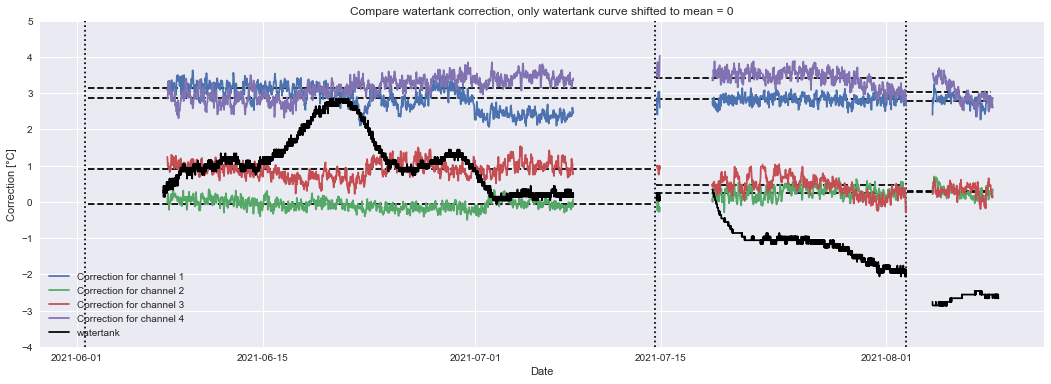

In [14]:
plot_segments_mean_correction(calibration_segments_mean_correction,dates,calibration_segments_mean_correction_dates,
    watertank_diff_log_data_all,df_Tlogger_PT100,watertank_len,ymax=5, ymin=-4)

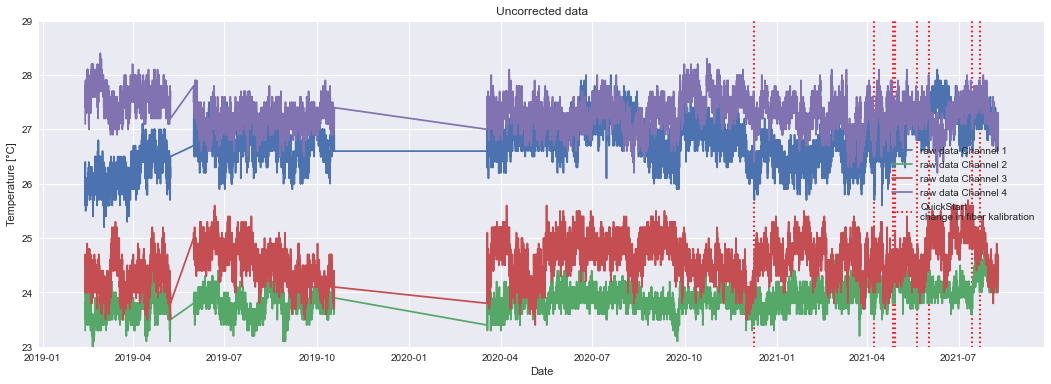

In [15]:
# PLOT NOCH SO BEARBEITEN; DASS ER WIE VON CH5-8 AUSSIEHT

length=500
from_date=0

fig,axs=plt.subplots(1,1,figsize=(18,6))

# Correction Segments
def color_cable_pos(calibration_segment, alph, ymax=30, ymin=20, col="black", label_name="none", label=False, axs=axs):
    """ creates patches which color the plot
    I slightly adapt this for every notebook
    """
    start_len = calibration_segment[0]
    end_len = calibration_segment[1]
    width = end_len - start_len
    Rectangle=patches.Rectangle(xy=[start_len,ymin],width=width,height=ymax-ymin,color=col,alpha=alph)
    axs.add_patch(Rectangle)
    if label:
        #axs.annotate(label_name,[start_len+width/2, ymax-(ymax-ymin)*0.9],size=15)
        bbox_props=dict(boxstyle="round",fc=col, ec="0.5", alpha=0.0)
        axs.text(start_len+width/2,ymax-(ymax-ymin)*0.9,label_name,ha="center",va="center",size=13,bbox=bbox_props)

# divide into segments of the same kalibration (QuickStart)
# ich glaube nicht das an jedem von diesem Datums der Quickstart neu gemacht wurde
string=["22-07-2021 13:30:29", "14-07-2021 14:16:59","2020-12-09 11:02:45", "2021-04-07 12:43:35", "2021-04-26 10:57:11",
    "2021-04-28 09:41:06", "2021-05-20 16:02:01", "2021-06-01 15:06:12"]
dates=[pd.to_datetime(s) for s in string]
axs.vlines(dates,20,30,colors="red",linestyle=":",label="QuickStart\nchange in fiber kalibration")

for chan in ["1","2","3","4"]:
    val=round(data_all[chan][length][from_date:][::5],1) #nur jeder 5 Wert
    axs.plot(val.index,val.values,label=f"raw data Channel {chan}")

axs.set_title("Uncorrected data")
axs.set_xlabel("Date")
axs.set_ylabel("Temperature [°C]")
axs.legend()
axs.set_ylim(23,29)

plt.show()

# peak nach unten anfang 2021, nochmal genaier angucken plots über die tiefe von einem datum angucken

# Schwankungen sind teilweise entgegengestzt von einaneder

In [16]:
# px.imshow(round(data_all["2"][::10],1),zmin=20,zmax=30)

In [17]:
#

# Correct data with const shift for each segment
Advantage: no datagaps (only the ones I want to have at segment borders)
at the moment the shift is determined with the data of the atertank correction for each sgement.

But especially for the older data of chan 1 - 4 I want to determine it from the raw data. This should be also usefull for the EGRT segment due to the large data gaps.

In [18]:
# only used every 10s value in processing the data
data_all_processed_constshifted = const_shift_data(["1","2","3","4"],calibration_segments, calibration_segments_mean_correction, data_all_processed_withoutTlogger)

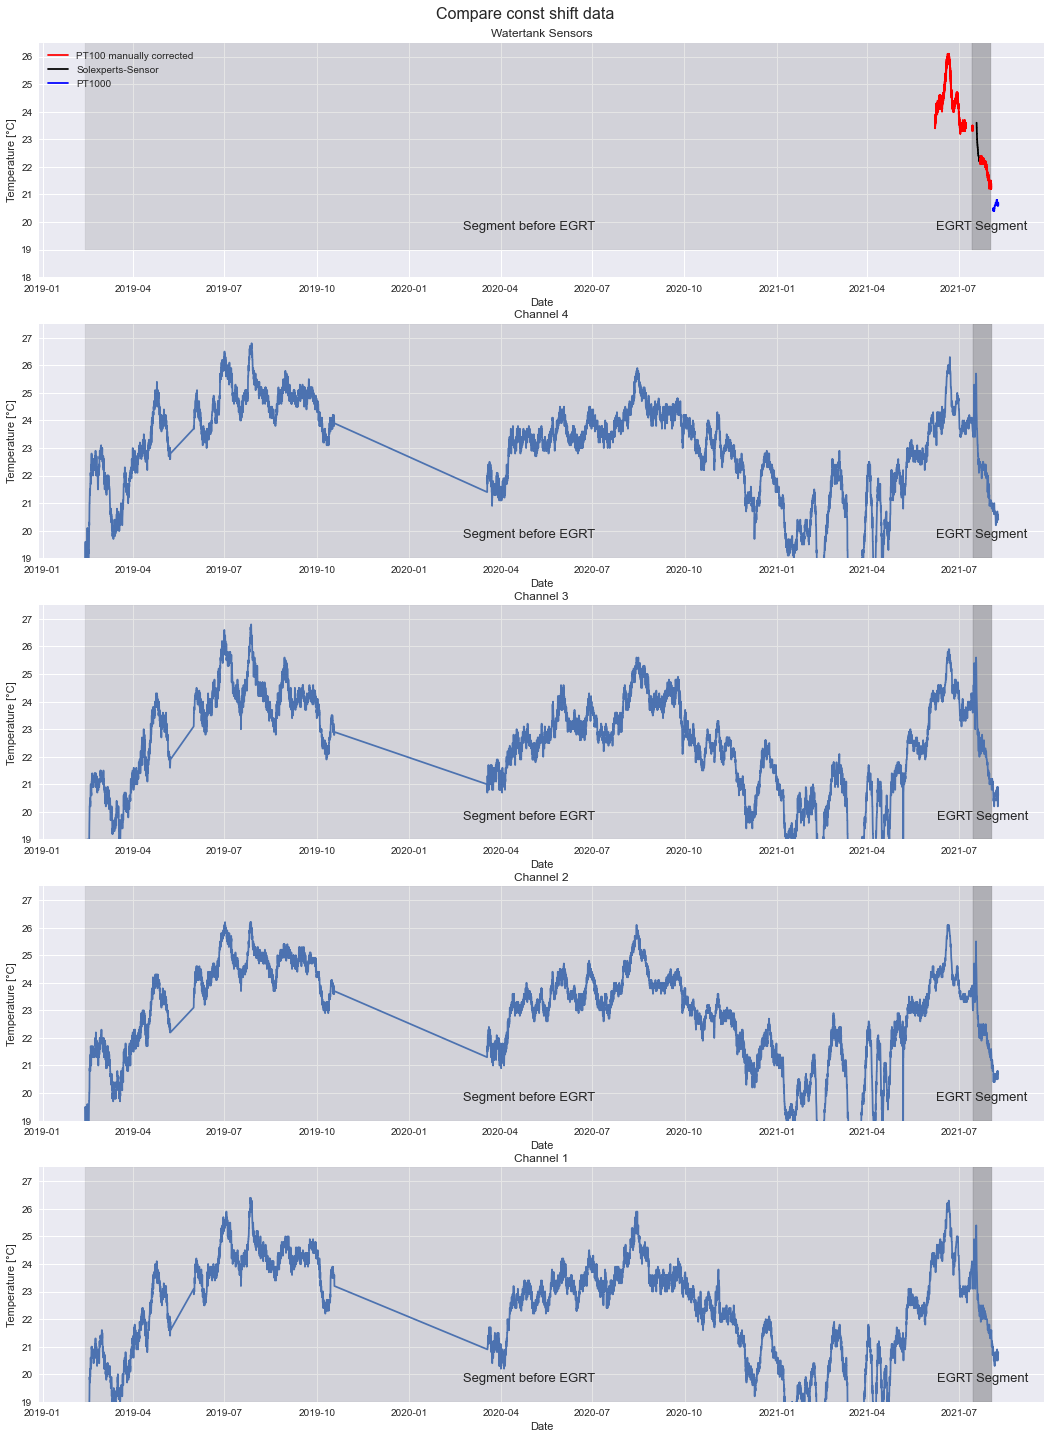

In [19]:
cable_length=watertank_len[0] #watertank_len=[71]
fig,axs=plt.subplots(5,1,figsize=(18,25))
fig.suptitle("Compare const shift data", fontsize = 16, y=0.90)
ymin=18; ymax=26.5
dftlog=df_Tlogger_PT100["Channel1-Watertank_PT100"]
# are not perfectly chosen, but due to data gaps its looks ok
border_temp1=20000
border_temp2=26000
border_temp3=32500
axs[0].plot(dftlog[:border_temp1].index,dftlog[:border_temp1].values,color="red", label="PT100 manually corrected")
axs[0].plot(dftlog[border_temp1:border_temp2].index,dftlog[border_temp1:border_temp2].values,color="black", label="Solexperts-Sensor")
axs[0].plot(dftlog[border_temp2:border_temp3].index,dftlog[border_temp2:border_temp3].values,color="red")
axs[0].plot(dftlog[border_temp3:].index,dftlog[border_temp3:].values,color="blue", label="PT1000")
#axs[0].vlines(dates,ymin,ymax,colors="black",linestyle=":")



axs[0].set_ylim(ymin,ymax)
axs[0].set_title("Watertank Sensors")
axs[0].legend()

ax_help=5; ymin=19; ymax=27.5 # same length as axs[0]
for chan in ["1","2","3","4"]:
    #axs.plot(data_all_processed_shifted[chan][800], label=f"variable shift, channel {chan},")#, color="blue")

    axs[ax_help-int(chan)].plot(data_all_processed_constshifted[chan][cable_length])#, color="green")
    
    axs[ax_help-int(chan)].set_title(f"Channel {chan}")
    axs[ax_help-int(chan)].set_ylim(ymin,ymax)

for ax in axs:
    #ax.legend()
    ax.set_ylabel("Temperature [°C]")
    ax.set_xlabel("Date")
    color_cable_pos(calibration_segments[0],0.1, ymax=ymax, ymin=ymin,axs=ax,label_name="Segment before EGRT", label=True)
    color_cable_pos(calibration_segments[1],0.25, ymax=ymax, ymin=ymin,axs=ax,label_name="EGRT Segment", label=True)
    # color_cable_pos(calibration_segments[2],0.1, ymax=ymax, ymin=ymin,axs=ax,label_name="Segment after EGRT", label=True)
    # color_cable_pos(calibration_segments[3],0.25, ymax=ymax, ymin=ymin,axs=ax,label_name="Segment after EGRT 2\nWhy is this there?\nneed to find report for this", label=False)

# wenn ich beim letzten Segment mehr Daten habe passt es evntl besser? Oder ich muss erstes Segment noch um 0.1 mehr verschieben?
# Vergleich zwischen channel 7 und 8 für zweites segment sehr komische
# es könnte auch sein, dass channel 8 bemessen wurde als die Heizphase gerade aus gemacht wurde
# Für diesen Test sind kurze Messzeiten auf Kosten der Genauigkeit besser, da sich Temperatur ja schnell ändert
# erklärt es aber eigentlich nicht wirklich, müsste dann trotzdem viel ähnlicher sein
# es sieht so aus als ob channel 8 in segment 2 noch Manuel etwas nach unten verschoben werden sollte
# letztes Segment in channel 7 manuel nach oben verschieben?